<a href="https://colab.research.google.com/github/hanzla-khalid98/challenge-2_AN2DL_2025/blob/main/notebooks/CNNDualPath_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dualpath CNN model



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import os
from pathlib import Path


# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
import torch.nn.functional as F # Added this line
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cuda


## PREPROCESSING

In [5]:
# list of files in train_data
files_train = os.listdir("/content/drive/MyDrive/data/train_data/")

images_train = []
masks_train = []

for file in files_train:
  if file.startswith("img"):
    images_train.append(file)
  elif file.startswith("mask"):
    masks_train.append(file)

# list of files in test_data
files_test = os.listdir("/content/drive/MyDrive/data/test_data/")

images_test = []
masks_test = []

for file in files_test:
  if file.startswith("img"):
    images_test.append(file)
  elif file.startswith("mask"):
    masks_test.append(file)

In [6]:
n_image_train = len(images_train)
n_mask_train = len(masks_train)

n_image_test = len(images_test)
n_mask_test = len(masks_test)


print(f"training dataset: {n_image_train} images, {n_mask_train} masks")
print(f"testing dataset: {n_image_test} images, {n_mask_test} masks")

training dataset: 691 images, 691 masks
testing dataset: 477 images, 477 masks


In [7]:
df = pd.read_csv("/content/drive/MyDrive/data/train_labels.csv")
df.head()

,sample_index,label
0,img_0000.png,Triple negative
1,img_0001.png,Luminal B
2,img_0002.png,Luminal B
3,img_0003.png,Luminal B
4,img_0004.png,Luminal B


In [8]:
# label proportions of train_label.csv

labels = df["label"].value_counts()
print(labels)

label
Luminal B          220
Luminal A          205
HER2(+)            189
Triple negative     77
Name: count, dtype: int64


In [9]:
root = "/content/drive/MyDrive/data/"

root_train = root + "train_data/"
root_test = root + "test_data/"

In [13]:
img_train, img_val, label_train, label_val = train_test_split(
    df['sample_index'], df['label'], test_size=0.15, random_state=42, stratify=df['label']
)

img_test = images_test

# Print the shapes of the resulting datasets
print("Training Data Shape:", img_train.shape)
print("Training Label Shape:", label_train.shape)
print("Validation Data Shape:", img_val.shape)
print("Validation Label Shape:", label_val.shape)

Training Data Shape: (587,)
Training Label Shape: (587,)
Validation Data Shape: (104,)
Validation Label Shape: (104,)


In [11]:
def is_green_artifact(tile, green_ratio_thresh=0.55):
    """
    Detect tiles dominated by green — typical scanner/histology artifacts.
    """
    # Compute channel means
    R_mean = tile[..., 0].mean()
    G_mean = tile[..., 1].mean()
    B_mean = tile[..., 2].mean()

    # Simple green ratio
    green_ratio = G_mean / (R_mean + B_mean + 1e-6)

    # Hard additional rule
    strong_green = (
        G_mean > R_mean * 1.15 and
        G_mean > B_mean * 1.15
    )

    return (green_ratio > green_ratio_thresh) or strong_green


def tile_and_filter(img, mask,
                    tile_size=256,
                    overlap=0.2,
                    min_mask_ratio=0.005,      # 0.5%
                    min_contrast=16.0,
                    remove_green=True):         # std threshold
    H, W = img.shape[:2]
    stride = int(tile_size * (1 - overlap))

    tiles_img = []
    tiles_mask = []

    for y in range(0, H - tile_size + 1, stride):
        for x in range(0, W - tile_size + 1, stride):

            img_tile = img[y:y + tile_size, x:x + tile_size]
            mask_tile = mask[y:y + tile_size, x:x + tile_size]

            # --- Remove green artifacts ---
            if remove_green and is_green_artifact(img_tile):
                continue

            # ---- compute interestingness ----
            mask_ratio = mask_tile.mean()
            contrast = img_tile.std()

            keep = (
                mask_ratio >= min_mask_ratio or
                contrast >= min_contrast
            )

            if keep:
                tiles_img.append(img_tile)
                tiles_mask.append(mask_tile)

    return (np.array(tiles_img) / 255).astype('float16'), np.array(tiles_mask)



In [15]:
import numpy as np
from PIL import Image

# Define the target size for the images. You can modify this as needed.
TARGET_SIZE = (128, 128) # Example: (height, width)
MIN_CONTRAST = 30.0
MIN_MASK_RATIO = 0.05
OVERLAP = 0.1

# Create empty lists to store the processed images

X_train_img_list = []
X_val_img_list = []
X_train_mask_list = []
X_val_mask_list = []
X_test_img_list = []
X_test_mask_list = []
y_train_list = []
y_val_list = []
images_train_name_list = []
images_val_name_list = []
images_test_name_list = []

# Process training images
nb_images_train = len(img_train)
print("Processing training images...")
for i, img_filename in enumerate(img_train):
    if (i + 1) % 100 == 0 or i == 0 or i == nb_images_train - 1:
        print(f"loading training image: {i + 1}/{nb_images_train}")
    img_path = os.path.join(root_train, img_filename)
    # Open image and mask as PIL objects
    pil_img = Image.open(img_path)
    mask_filename = "mask_" + img_filename.split("_")[1]
    mask_path = os.path.join(root_train, mask_filename)
    pil_mask = Image.open(mask_path, )

    # Convert PIL images to NumPy arrays for extract_roi_tiles
    img_np = np.array(pil_img)
    mask_np = (np.array(pil_mask) / 255).astype("float16")

    # Extract tiles using the NumPy arrays
    tiles_img, tiles_mask = tile_and_filter(img_np, mask_np, tile_size=TARGET_SIZE[0], overlap=OVERLAP, min_mask_ratio=MIN_MASK_RATIO, min_contrast=MIN_CONTRAST)

    # create mapping for label of tiles
    label = df[df["sample_index"] == img_filename]["label"].values[0]
    y_train_list.extend([label for _ in range(len(tiles_img))])

    # keep the name of image file for each tile
    images_train_name_list.extend([img_filename for _ in range(len(tiles_img))])

    X_train_img_list.extend(tiles_img)
    X_train_mask_list.extend(tiles_mask)
X_train_img = np.array(X_train_img_list)
X_train_mask = np.array(X_train_mask_list)
y_train = np.array(y_train_list)
images_train_name = np.array(images_train_name_list)
print(f"X_train_val created with shape: {X_train_img.shape}")
print(f"Each training tile is represented as a {TARGET_SIZE[0]}x{TARGET_SIZE[1]} RGB matrix.\n")

del X_train_img_list, X_train_mask_list, y_train_list

# Process val images
nb_images_val = len(img_val)
print("Processing training images...")
for i, img_filename in enumerate(img_val):
    if (i + 1) % 100 == 0 or i == 0 or i == nb_images_val - 1:
        print(f"loading training image: {i + 1}/{nb_images_val}")
    img_path = os.path.join(root_train, img_filename)
    # Open image and mask as PIL objects
    pil_img = Image.open(img_path)
    mask_filename = "mask_" + img_filename.split("_")[1]
    mask_path = os.path.join(root_train, mask_filename)
    pil_mask = Image.open(mask_path, )

    # Convert PIL images to NumPy arrays for extract_roi_tiles
    img_np = np.array(pil_img)
    mask_np = (np.array(pil_mask) / 255).astype("float16")

    # Extract tiles using the NumPy arrays
    tiles_img, tiles_mask = tile_and_filter(img_np, mask_np, tile_size=TARGET_SIZE[0], overlap=OVERLAP, min_mask_ratio=MIN_MASK_RATIO, min_contrast=MIN_CONTRAST)

    # create mapping for label of tiles
    label = df[df["sample_index"] == img_filename]["label"].values[0]
    y_val_list.extend([label for _ in range(len(tiles_img))])


    # keep the name of image file for each tile
    images_val_name_list.extend([img_filename for _ in range(len(tiles_img))])

    X_val_img_list.extend(tiles_img)
    X_val_mask_list.extend(tiles_mask)
X_val_img = np.array(X_val_img_list)
X_val_mask = np.array(X_val_mask_list)
y_val = np.array(y_val_list)
images_val_name = np.array(images_val_name_list)
print(f"X_val created with shape: {X_val_img.shape}")
print(f"Each validation tile is represented as a {TARGET_SIZE[0]}x{TARGET_SIZE[1]} RGB matrix.\n")

del X_val_img_list, X_val_mask_list, y_val_list

# Process testing images
nb_images_test = len(img_test)
print("Processing testing images...")
for i, img_filename in enumerate(img_test):
    if (i + 1) % 100 == 0 or i == 0 or i == nb_images_test - 1:
        print(f"loading testing image: {i + 1}/{nb_images_test}")
    img_path = os.path.join(root_test, img_filename)
    # Open image and mask as PIL objects
    pil_img = Image.open(img_path)
    mask_filename = "mask_" + img_filename.split("_")[1]
    mask_path = os.path.join(root_test, mask_filename)
    pil_mask = Image.open(mask_path)

    # Convert PIL images to NumPy arrays for extract_roi_tiles
    img_np = np.array(pil_img)
    mask_np = (np.array(pil_mask) / 255).astype("float16")

    # Extract tiles using the NumPy arrays
    tiles_img, tiles_mask = tile_and_filter(img_np, mask_np, tile_size=TARGET_SIZE[0], overlap=OVERLAP, min_mask_ratio=MIN_MASK_RATIO, min_contrast=MIN_CONTRAST)

    # keep the name of image file for each tile
    images_test_name_list.extend([img_filename for _ in range(len(tiles_img))])

    X_test_img_list.extend(tiles_img)
    X_test_mask_list.extend(tiles_mask)
X_test_img = np.array(X_test_img_list)
X_test_mask = np.array(X_test_mask_list)
images_test_name = np.array(images_test_name_list)
print(f"X_test_val created with shape: {X_test_img.shape}")
print(f"Each testing tile is represented as a {TARGET_SIZE[0]}x{TARGET_SIZE[1]} RGB matrix.")

del X_test_img_list, X_test_mask_list, images_test_name_list

Processing training images...
loading training image: 1/587
loading training image: 100/587
loading training image: 200/587
loading training image: 300/587
loading training image: 400/587
loading training image: 500/587
loading training image: 587/587
X_train_val created with shape: (7530, 128, 128, 3)
Each training tile is represented as a 128x128 RGB matrix.

Processing training images...
loading training image: 1/104
loading training image: 100/104
loading training image: 104/104
X_val created with shape: (1471, 128, 128, 3)
Each validation tile is represented as a 128x128 RGB matrix.

Processing testing images...
loading testing image: 1/477
loading testing image: 100/477
loading testing image: 200/477
loading testing image: 300/477
loading testing image: 400/477
loading testing image: 477/477
X_test_val created with shape: (5295, 128, 128, 3)
Each testing tile is represented as a 128x128 RGB matrix.


In [16]:

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train_img.shape, X_train_mask.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val_img.shape)
print("Validation Label Shape:", y_val.shape)


Training Data Shape: (7530, 128, 128, 3) (7530, 128, 128)
Training Label Shape: (7530,)
Validation Data Shape: (1471, 128, 128, 3)
Validation Label Shape: (1471,)


In [17]:
#mapping
class_mapping = {
    "Triple negative": 0,
    "Luminal A": 1,
    "Luminal B": 2,
    "HER2(+)": 3
}

y_train = np.array([class_mapping[label] for label in y_train])
y_val   = np.array([class_mapping[label] for label in y_val])

In [18]:
# compute class weight
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([2.3981, 0.8090, 0.8876, 0.8195])

In [20]:
from torch.utils.data import Dataset

class DualInputDataset(Dataset):
    def __init__(self, imgs, masks, labels=None, images_id=None, transform=None):
        self.imgs = imgs
        self.masks = masks
        self.labels = labels
        self.transform = transform
        self.images_id = images_id

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        output = []
        # Convert numpy array (H, W, C) float16 to torch tensor (C, H, W) float32
        # `transforms.ToTensor()` correctly handles numpy arrays with HWC order and scales to [0,1] if not already.
        # Explicitly cast to float32 to ensure correct type if numpy array is float16.
        img = transforms.ToTensor()(self.imgs[idx]).to(torch.float32)

        # Mask is (H, W) float16, convert to (1, H, W) float32
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).unsqueeze(0)


        if self.transform:
            img = self.transform(img) # Now self.transform (RandAugment) receives a torch.Tensor

        output.append(img)
        output.append(mask)

        if self.labels is not None:
            label = self.labels[idx]
            output.append(label)

        if self.images_id is not None:
            image_id = self.images_id[idx]
            output.append(image_id)

        return output


# Now train_augmentation only needs the specific augmentation transforms as the initial
# conversion to tensor (C, H, W) is handled inside DualInputDataset's __getitem__.
train_augmentation = transforms.Compose([
    transforms.RandAugment(num_ops=2, magnitude=8),
])


train_ds = DualInputDataset(X_train_img, X_train_mask, y_train, transform=train_augmentation)
val_ds   = DualInputDataset(X_val_img, X_val_mask, y_val, images_val_name, transform=None)
test_ds  = DualInputDataset(X_test_img, X_test_mask, labels=None, images_id=images_test_name, transform=None)

In [21]:
BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128


def make_loader(dataset, batch_size, shuffle, drop_last):
    """Wrap tensors in a DataLoader."""
    # Setting num_workers to 0 disables multiprocessing for data loading
    # and often resolves issues with FileNotFoundError in _pin_memory_loop
    # Set pin_memory to False as it's often problematic with num_workers > 0 in Colab
    # If performance is an issue, consider experimenting with num_workers = 1 and pin_memory=True
    num_workers = 0 # os.cpu_count() or 2
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=False, # Changed to False
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=None, # Changed to None as num_workers is 0
    )

train_loader = make_loader(train_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, EVAL_BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, EVAL_BATCH_SIZE, shuffle=False, drop_last=False)


# Handy metadata for configuring the model
input_size = X_train_img.shape[1:]
num_classes = len(torch.unique(torch.tensor(y_train)))
print(f"Input size: {input_size}, classes: {num_classes}")

Input size: (128, 128, 3), classes: 4


In [22]:
# Fetch a batch to capture the per-sample input shape for summaries
for xb_img, xb_mask, yb in train_loader:
    input_shape = xb_img.shape[1:]
    num_classes = len(np.unique(yb.cpu().numpy()))
    break

print(f"Input shape per sample: {input_shape}")

Input shape per sample: torch.Size([3, 128, 128])


##🛠️ Inception Block (GoogLeNet, 2014)

Key Features and Achievements

Multi-scale feature processing
Winner of ILSVRC 2014
Key building block:

Parallel paths with different kernels
1x1 bottleneck for efficiency
Feature concatenation
Impact:

Established multi-path processing
Introduced 1x1 bottleneck concept

In [34]:
class ConvGNReLU(nn.Module):
    def __init__(
        self,
        in_c,
        out_c,
        k=3,
        s=1,
        p=1,
        gn_groups=8,
        act=nn.ReLU
    ):
        super().__init__()

        self.conv = nn.Conv2d(in_c, out_c, k, s, p, bias=False)

        # Safe GroupNorm selection
        num_groups = min(gn_groups, out_c)
        while out_c % num_groups != 0:
            num_groups -= 1

        self.norm = nn.GroupNorm(num_groups=num_groups, num_channels=out_c)
        self.act = act(inplace=True)

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))



In [35]:
class InceptionLite(nn.Module):
    def __init__(
        self,
        in_c,
        out_c,
        ratios=(0.25, 0.25, 0.25, 0.25),
        gn_groups=8
    ):
        super().__init__()
        r1, r3, r5, rp = ratios

        c1 = int(out_c * r1)
        c3 = int(out_c * r3)
        c5 = int(out_c * r5)
        cp = out_c - (c1 + c3 + c5)  # remainder safe

        self.b1 = ConvGNReLU(in_c, c1, k=1, p=0, gn_groups=gn_groups)

        self.b3 = nn.Sequential(
            ConvGNReLU(in_c, c3 // 2, k=1, p=0, gn_groups=gn_groups),
            ConvGNReLU(c3 // 2, c3, k=3, p=1, gn_groups=gn_groups),
        )

        self.b5 = nn.Sequential(
            ConvGNReLU(in_c, c5 // 2, k=1, p=0, gn_groups=gn_groups),
            ConvGNReLU(c5 // 2, c5, k=5, p=2, gn_groups=gn_groups),
        )

        self.pool = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            ConvGNReLU(in_c, cp, k=1, p=0, gn_groups=gn_groups),
        )

    def forward(self, x):
        return torch.cat(
            [self.b1(x), self.b3(x), self.b5(x), self.pool(x)],
            dim=1,
        )


In [36]:
class DualPathNet(nn.Module):
    def __init__(
        self,
        num_classes,
        base_channels=32,
        img_blocks=(64, 128),
        mask_blocks=(32, 64),
        inception_ratios=(0.25, 0.25, 0.25, 0.25),
        gn_groups=8,
        dropout=0.4
    ):
        super().__init__()

        # IMAGE PATH
        self.img_stem = ConvGNReLU(
            3, base_channels, gn_groups=gn_groups
        )

        img_layers = []
        in_c = base_channels
        for out_c in img_blocks:
            img_layers.append(
                InceptionLite(
                    in_c,
                    out_c,
                    ratios=inception_ratios,
                    gn_groups=gn_groups,
                )
            )
            in_c = out_c
        self.img_path = nn.Sequential(*img_layers)

        # MASK PATH
        self.mask_stem = ConvGNReLU(
            1, base_channels // 2, gn_groups=gn_groups
        )

        mask_layers = []
        in_c = base_channels // 2
        for out_c in mask_blocks:
            mask_layers.append(
                ConvGNReLU(
                    in_c, out_c, gn_groups=gn_groups
                )
            )
            in_c = out_c
        self.mask_path = nn.Sequential(*mask_layers)

        # FUSION HEAD
        fusion_dim = img_blocks[-1] + mask_blocks[-1]

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, num_classes),
        )

    def forward(self, img, mask):
        xi = self.img_path(self.img_stem(img))
        xm = self.mask_path(self.mask_stem(mask))

        xm = F.interpolate(
            xm, size=xi.shape[-2:], mode="nearest"
        )

        x = torch.cat([xi, xm], dim=1)
        return self.head(x)  # logits


## training and evaluating functions

In [37]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (imgs, masks, labels) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(imgs, masks)
            loss = criterion(logits, labels)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * imgs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [38]:
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import torch

def validate_one_epoch(
    model,
    val_loader,
    criterion,
    device,
    top_k=5,
):
    """
    Validation that EXACTLY mimics test-time behavior:
    - tile inference
    - confidence-based aggregation
    - image-level F1 score
    """

    model.eval()
    running_loss = 0.0

    all_logits = []
    all_confs = []
    all_labels = []
    all_image_ids = []

    with torch.no_grad():
        for imgs, masks, labels, image_ids in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            with torch.amp.autocast(
                device_type=device.type,
                enabled=(device.type == "cuda"),
            ):
                logits = model(imgs, masks)
                loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)

            probs = torch.softmax(logits, dim=1)
            confs = probs.max(dim=1).values

            all_logits.append(logits.cpu())
            all_confs.append(confs.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_image_ids.extend(image_ids)

    # --- Tile-level → Image-level aggregation ---
    all_logits = torch.cat(all_logits).numpy()
    all_confs = torch.cat(all_confs).numpy()

    df_tiles = pd.DataFrame({
        "image_id": all_image_ids,
        "label": all_labels,
        "confidence": all_confs,
    })

    y_true = []
    y_pred = []

    for img_id, group in df_tiles.groupby("image_id"):
        # Top-K confident tiles (same as test)
        group = group.sort_values("confidence", ascending=False).head(top_k)
        idxs = group.index.values

        image_logits = all_logits[idxs].mean(axis=0)
        pred = int(np.argmax(image_logits))

        y_pred.append(pred)
        y_true.append(group["label"].iloc[0])  # same label per image

    epoch_loss = running_loss / len(val_loader.dataset)

    epoch_f1 = f1_score(
        y_true,
        y_pred,
        average="macro"   # competition-safe choice
    )

    return epoch_loss, epoch_f1


In [39]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, scheduler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device, top_k=5
        )

        scheduler.step()

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)


        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## Hyperparameters

In [70]:
# Number of training epochs
LEARNING_RATE = 5e-4
EPOCHS = 100
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.3        # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights.to(device))

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 100
Batch Size: 64
Learning Rare: 0.0005
Dropout Rate: 0.3
L1 Penalty: 0
L2 Penalty: 0


In [71]:
# CNN Architecture parameters
# Number of convolutional blocks
NUM_BLOCKS = 3

# Number of conv layers per block
CONVS_PER_BLOCK = 2

# Use strided convolutions instead of pooling
USE_STRIDE = False

# Stride value when USE_STRIDE is True
STRIDE_VALUE = 2

# Padding size
PADDING_SIZE = 1

# Pooling size when USE_STRIDE is False
POOL_SIZE = 2

# Number of channels in first block
INITIAL_CHANNELS = 48

IMG_BLOCK = (96, 192)
MASK_BLOCK = (48, 96)

# Channel multiplication factor between blocks
CHANNEL_MULTIPLIER = 2

print("Num Blocks:", NUM_BLOCKS)
print("Convs per Block:", CONVS_PER_BLOCK)
print("Use Stride:", USE_STRIDE)
print("Stride Value:", STRIDE_VALUE)
print("Padding Size:", PADDING_SIZE)
print("Pool Size:", POOL_SIZE)
print("Initial Channels:", INITIAL_CHANNELS)
print("Channel Multiplier:", CHANNEL_MULTIPLIER)

Num Blocks: 3
Convs per Block: 2
Use Stride: False
Stride Value: 2
Padding Size: 1
Pool Size: 2
Initial Channels: 48
Channel Multiplier: 2


## Training

In [72]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [73]:
dualpath_model = DualPathNet(
    num_classes=4,
    base_channels=INITIAL_CHANNELS,
    img_blocks=IMG_BLOCK,
    mask_blocks=MASK_BLOCK,
    dropout=DROPOUT_RATE,
).to(device)

# Affichage du résumé
summary(dualpath_model, input_size=[input_shape, (1, input_shape[1], input_shape[2])])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 128, 128]           1,296
         GroupNorm-2         [-1, 48, 128, 128]              96
              ReLU-3         [-1, 48, 128, 128]               0
        ConvGNReLU-4         [-1, 48, 128, 128]               0
            Conv2d-5         [-1, 24, 128, 128]           1,152
         GroupNorm-6         [-1, 24, 128, 128]              48
              ReLU-7         [-1, 24, 128, 128]               0
        ConvGNReLU-8         [-1, 24, 128, 128]               0
            Conv2d-9         [-1, 12, 128, 128]             576
        GroupNorm-10         [-1, 12, 128, 128]              24
             ReLU-11         [-1, 12, 128, 128]               0
       ConvGNReLU-12         [-1, 12, 128, 128]               0
           Conv2d-13         [-1, 24, 128, 128]           2,592
        GroupNorm-14         [-1, 24, 1

In [74]:
# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(dualpath_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,       # your total epochs
    eta_min=1e-6
)

In [75]:
experiment_name = "cnn_dualpath_2"

writer = SummaryWriter(f"./{logs_dir}/cnn")


# %%time
# Train model and track training history
dualpath_model, training_history = fit(
    model=dualpath_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    device=device,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    patience=PATIENCE,
    evaluation_metric="val_f1",
    mode='max',
    restore_best_weights=True,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = dualpath_model # Changed from inception_model to dualpath_model
    best_performance = training_history['val_f1'][-1]

Training 100 epochs...
Epoch   1/100 | Train: Loss=1.3965, F1 Score=0.3095 | Val: Loss=1.2844, F1 Score=0.2284
Epoch   2/100 | Train: Loss=1.3488, F1 Score=0.3593 | Val: Loss=1.2331, F1 Score=0.3086
Epoch   3/100 | Train: Loss=1.3267, F1 Score=0.3874 | Val: Loss=1.2197, F1 Score=0.3292
Epoch   4/100 | Train: Loss=1.3142, F1 Score=0.3962 | Val: Loss=1.2061, F1 Score=0.2224
Epoch   5/100 | Train: Loss=1.3023, F1 Score=0.3912 | Val: Loss=1.1931, F1 Score=0.2591
Epoch   6/100 | Train: Loss=1.2969, F1 Score=0.3987 | Val: Loss=1.1879, F1 Score=0.2669
Epoch   7/100 | Train: Loss=1.2960, F1 Score=0.3921 | Val: Loss=1.1865, F1 Score=0.3650
Epoch   8/100 | Train: Loss=1.2960, F1 Score=0.4045 | Val: Loss=1.1903, F1 Score=0.2350
Epoch   9/100 | Train: Loss=1.2903, F1 Score=0.3921 | Val: Loss=1.1896, F1 Score=0.2469
Epoch  10/100 | Train: Loss=1.2831, F1 Score=0.4064 | Val: Loss=1.1782, F1 Score=0.2331
Epoch  11/100 | Train: Loss=1.2762, F1 Score=0.4160 | Val: Loss=1.1758, F1 Score=0.2919
Epoch  12

## Evaluation

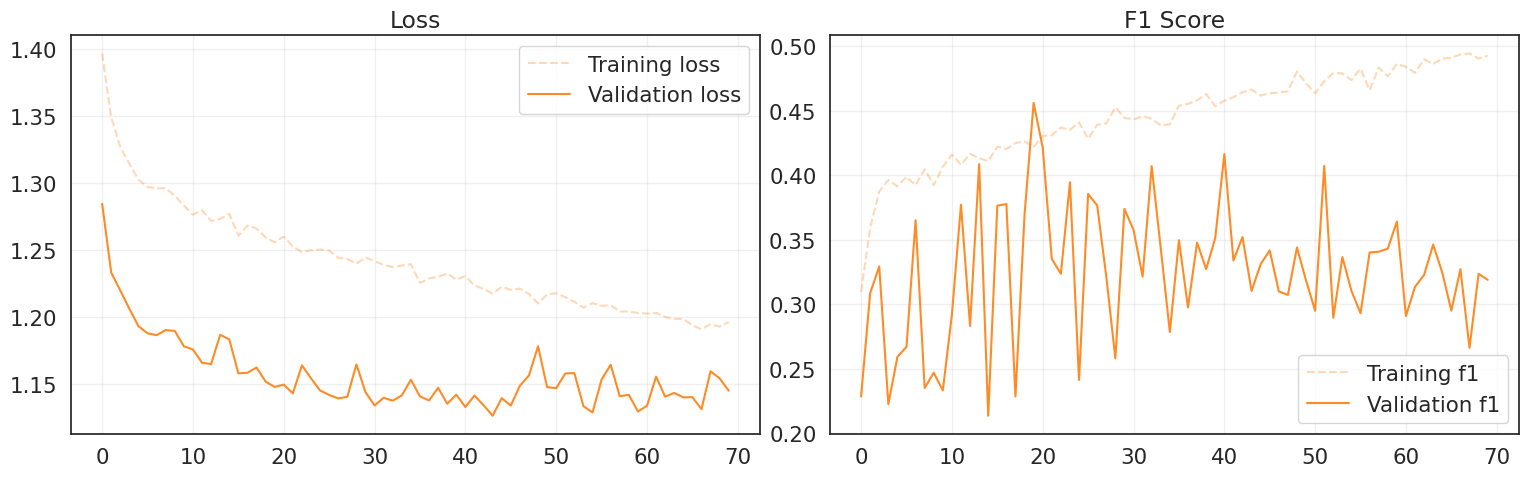

In [78]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.5235
Precision over the validation set: 0.6253
Recall over the validation set: 0.5235
F1 score over the validation set: 0.5430


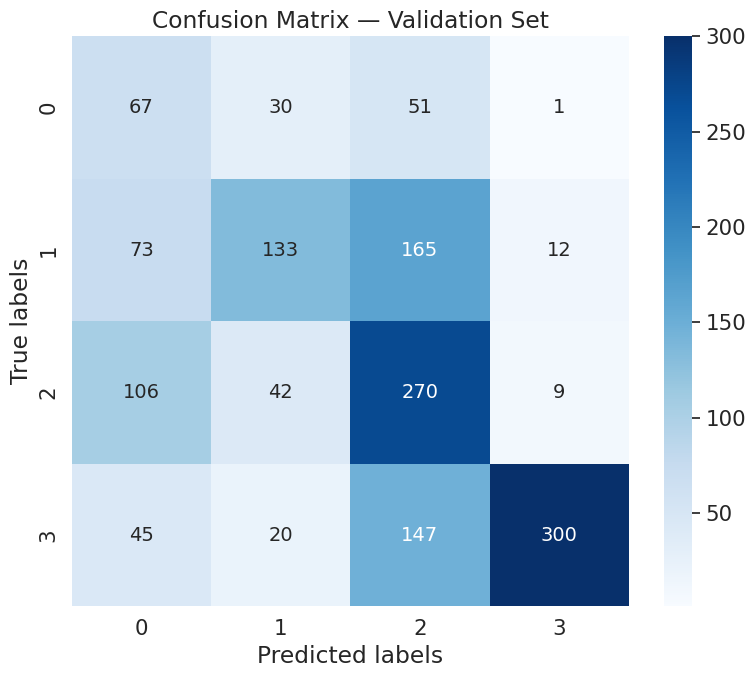

In [77]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for imgs, masks, labels, img_id in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        # Permute dimensions from (batch_size, height, width, channels) to (batch_size, channels, height, width)
        # This line is now redundant and incorrect as data is already (Batch, Channels, Height, Width)
        # xb = xb.permute(0, 3, 1, 2)

        # Forward pass: get model predictions
        logits = dualpath_model(imgs, masks)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(labels.cpu().numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [ ]:
# ----------------------------
# Hyperparameter search space
# ----------------------------

def grid_search(
    param_grid,
    input_shape,
    num_classes,
    train_loader,
    val_loader,
    criterion,
    device,
    base_config=None,
    max_epochs=100,
    patience=15,
    weight_decay=0.0,
    verbose=1,
    save_path="models/best_cnn_grid_search.pt"
):
    """
    Performs grid search over hyperparameters for the CNN model.

    param_grid: dict of lists
    base_config: optional dictionary of CNN parameters to keep fixed
    """

    import itertools
    import copy

    # Expand hyperparameter grid
    all_configs = list(itertools.product(*param_grid.values()))
    print(f"\nTotal configurations: {len(all_configs)}\n")

    results = []
    best_score = -float("inf")
    best_params = None
    best_model_state = None

    # Training loop over all combinations
    for config in all_configs:
        hparams = dict(zip(param_grid.keys(), config))

        # Merge with fixed parameters (if provided)
        if base_config:
            full_params = {**base_config, **hparams}
        else:
            full_params = hparams

        print("\n========================================")
        print("Testing configuration:", full_params)
        print("========================================")


        # Build model using supplied parameters
        model = InceptionModel(
            input_shape=input_shape,
            output_shape=num_classes,
            num_blocks=full_params["num_blocks"],
            stack=full_params["stack"],
            initial_channels=full_params["initial_channels"],
            channel_multiplier=full_params["channel_multiplier"],
            dropout_rate=full_params["dropout_rate"],
            use_stride=full_params["use_stride"],
            stride_value=full_params["stride_value"],
            padding_size=full_params["padding_size"],
            pool_size=full_params["pool_size"],
        ).to(device)
        # Optimizer
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=full_params["lr"],
            weight_decay=weight_decay
        )

        # AMP scaler
        scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Train model
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=max_epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            scheduler=scheduler,
            device=device,
            patience=patience,
            experiment_name="grid_temp",
            verbose=0,
        )

        # Score to compare models
        val_f1 = np.max(history["val_f1"])
        print(f" → F1 Score: {val_f1:.4f}")

        # Save results
        row = full_params.copy()
        row["val_f1"] = val_f1
        results.append(row)

        # Track best model
        if val_f1 > best_score:
            best_score = val_f1
            best_params = full_params.copy()
            best_model_state = copy.deepcopy(model.state_dict())

        # Free GPU memory
        del model
        torch.cuda.empty_cache()

    # Save best model
    torch.save(best_model_state, save_path)

    print("\n========================")
    print("Best hyperparameters:")
    print(best_params)
    print("Best F1:", best_score)
    print("========================")

    # Return results as DataFrame
    return pd.DataFrame(results), best_params, best_score


In [ ]:
param_grid = {
    "num_blocks":        [1, 2, 3],
    "stack":   [1, 2],
    "initial_channels":  [16, 32],
    "channel_multiplier":[2],
    "dropout_rate":      [0.0, 0.2, 0.4],
    "lr":                [1e-3, 5e-4, 1e-4],
}

# Fixed parameters (architecture options you don't want to grid-search)
base_config = {
    "use_stride": USE_STRIDE,
    "stride_value": STRIDE_VALUE,
    "padding_size": PADDING_SIZE,
    "pool_size": POOL_SIZE,
}

df_results, best_params, best_score = grid_search(
    param_grid=param_grid,
    input_shape=input_shape,
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
    base_config=base_config,
    weight_decay=L2_LAMBDA,
    max_epochs=100,
    patience=15,
    save_path="models/best_cnn_grid_search.pt"
)



Total configurations: 108


Testing configuration: {'use_stride': False, 'stride_value': 2, 'padding_size': 1, 'pool_size': 2, 'num_blocks': 1, 'stack': 1, 'initial_channels': 16, 'channel_multiplier': 2, 'dropout_rate': 0.0, 'lr': 0.001}
Training 100 epochs...
Early stopping triggered after 47 epochs.
Best model restored from epoch 32 with val_f1 0.2633
 → F1 Score: 0.2633

Testing configuration: {'use_stride': False, 'stride_value': 2, 'padding_size': 1, 'pool_size': 2, 'num_blocks': 1, 'stack': 1, 'initial_channels': 16, 'channel_multiplier': 2, 'dropout_rate': 0.0, 'lr': 0.0005}
Training 100 epochs...
Early stopping triggered after 26 epochs.
Best model restored from epoch 11 with val_f1 0.2952
 → F1 Score: 0.2952

Testing configuration: {'use_stride': False, 'stride_value': 2, 'padding_size': 1, 'pool_size': 2, 'num_blocks': 1, 'stack': 1, 'initial_channels': 16, 'channel_multiplier': 2, 'dropout_rate': 0.0, 'lr': 0.0001}
Training 100 epochs...
Early stopping triggered after 18 e

## Inference

In [52]:
dualpath_model = best_model


In [79]:

def make_prediction(model, test_loader, temperature, top_k, output):
  all_logits = []
  all_confs = []
  all_image_ids = []

  dualpath_model.eval()

  with torch.no_grad():
      for imgs, masks, image_ids in test_loader:
          imgs = imgs.to(device)
          masks = masks.to(device)

          logits = dualpath_model(imgs, masks)   # (B, C)

          probs = torch.softmax(logits, dim=1)
          confs = probs.max(dim=1).values          # (B,)

          all_logits.append(logits.cpu())
          all_confs.append(confs.cpu())
          all_image_ids.extend(image_ids)

  import numpy as np
  import pandas as pd

  all_logits = torch.cat(all_logits, dim=0).numpy()   # (N_tiles, C)
  all_confs  = torch.cat(all_confs, dim=0).numpy()    # (N_tiles,)

  df_tiles = pd.DataFrame({
      "image_id": all_image_ids,
      "confidence": all_confs
  })

  final_preds = {}

  for img_id, group in df_tiles.groupby("image_id"):

      # 1️⃣ Top-K confident tiles
      group = group.sort_values("confidence", ascending=False).head(top_k)
      idxs = group.index.values

      tile_logits = all_logits[idxs]              # (K, C)
      tile_confs  = group["confidence"].values    # (K,)

      # 2️⃣ Confidence → weights
      weights = np.exp(tile_confs / temperature)
      weights = weights / weights.sum()

      # 3️⃣ Weighted logit aggregation
      image_logits = (tile_logits * weights[:, None]).sum(axis=0)

      # 4️⃣ Final prediction
      final_preds[img_id] = int(np.argmax(image_logits))

  final_preds["img_0034.png"] = 2

  df_preds = (
      pd.DataFrame({
          "sample_index": list(final_preds.keys()),
          "label": list(final_preds.values())
      })
      .sort_values("sample_index")
      .reset_index(drop=True)
  )

  # mapping labels
  class_mapping_inverse = {
    0: 'Triple negative',
    1: 'Luminal A',
    2: 'Luminal B',
    3: 'HER2(+)'
  }

  df_preds['label'] = df_preds['label'].map(class_mapping_inverse)
  df_preds.to_csv(output, index=False, header=True)

  # print class frequency in df_preds
  print(f"{output}: {df_preds['label'].value_counts()}")



In [82]:
TOP_K = [7, 12, 15]
TEMPERATURE = [0.1, 0.2, 0.5]

for k in TOP_K:
  for t in TEMPERATURE:
    make_prediction(
        model=dualpath_model,
        test_loader=test_loader,
        temperature=t,
        top_k=k,
        output=f"predictions_k{k}_t{t}.csv"
    )

predictions_k7_t0.1.csv: label
Luminal B          330
Luminal A           78
Triple negative     60
HER2(+)              9
Name: count, dtype: int64
predictions_k7_t0.2.csv: label
Luminal B          340
Luminal A           71
Triple negative     57
HER2(+)              9
Name: count, dtype: int64
predictions_k7_t0.5.csv: label
Luminal B          345
Luminal A           66
Triple negative     57
HER2(+)              9
Name: count, dtype: int64
predictions_k12_t0.1.csv: label
Luminal B          339
Luminal A           76
Triple negative     53
HER2(+)              9
Name: count, dtype: int64
predictions_k12_t0.2.csv: label
Luminal B          350
Luminal A           68
Triple negative     50
HER2(+)              9
Name: count, dtype: int64
predictions_k12_t0.5.csv: label
Luminal B          356
Luminal A           65
Triple negative     48
HER2(+)              8
Name: count, dtype: int64
predictions_k15_t0.1.csv: label
Luminal B          342
Luminal A           74
Triple negative     51
HE

In [69]:
# label frequency
df_preds['label'].value_counts()

,count
label,
2,375
0,48
1,47
3,7


In [59]:
# mapping labels
class_mapping_inverse = {
    0: 'Triple negative',
    1: 'Luminal A',
    2: 'Luminal B',
    3: 'HER2(+)'
}

df_preds['label'] = df_preds['label'].map(class_mapping_inverse)
# df_preds["sample_index"] = df_preds["sample_index"].apply(lambda x: f"img_{int(x):04d}.png")

In [60]:
df_preds.to_csv('predictions.csv', index=False, header=True)